<a href="https://colab.research.google.com/github/TasneemElgendy/teeth_detection_pretraind_model/blob/main/PretraindModels_Teeth_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports:

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, ResNet50
AUTOTUNE = tf.data.AUTOTUNE
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load data:

link of dataset: https://drive.google.com/file/d/1WEySXMFz6v1OgPkLKJ8QIp3Lk-eyTObY/view

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/MyDrive/Teeth DataSet.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Teeth_Dataset/Validation/CoS/b_111_0_6094.jpg  
  inflating: Teeth_Dataset/Testing/CoS/b_150_0_2905.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1241_0_1157.jpg  
  inflating: Teeth_Dataset/Validation/CoS/b_95 - Copy_0_6372.jpg  
  inflating: Teeth_Dataset/Testing/CaS/a_152_0_7749.jpg  
  inflating: Teeth_Dataset/Testing/CaS/a_126_0_9339.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_110_0_9820.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_141_0_7620.jpg  
  inflating: Teeth_Dataset/Validation/CoS/b_132_0_2266.jpg  
  inflating: Teeth_Dataset/Testing/outputs/a_99_0_9803.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1223_0_6812.jpg  
  inflating: Teeth_Dataset/Testing/OT/ot_1223_0_6082.jpg  
  inflating: Teeth_Dataset/Testing/output/a_145_0_219.jpg  
  inflating: Teeth_Dataset/Testing/output/a_119_0_1965.jpg  
  inflating: Teeth_Dataset/Testing/CoS/b_112_0_1990.jpg  
  inflating: Teeth_Dataset/Testing/output/a_1

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/Teeth_Dataset/Training"
val_dir = "/content/Teeth_Dataset/Validation"
test_dir = "/content/Teeth_Dataset/Testing"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
class_names = ['CaS', 'CoS', 'Gum', 'MC', 'OC', 'OLP', 'OT']

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [ ]:
class_names = train_ds.class_names
class_counts = {}

for images, labels in train_ds.unbatch():
    label = int(labels.numpy())
    class_counts[class_names[label]] = class_counts.get(class_names[label], 0) + 1

In [ ]:
print (class_counts)

{'CoS': 450, 'MC': 540, 'OT': 393, 'OLP': 540, 'Gum': 360, 'CaS': 480, 'OC': 324}


In [ ]:
val_class_counts = {}

for images, labels in val_ds.unbatch():
    label = int(labels.numpy())
    val_class_counts[class_names[label]] = val_class_counts.get(class_names[label], 0) + 1
print (val_class_counts)

{'CoS': 149, 'MC': 180, 'OC': 108, 'Gum': 120, 'OT': 131, 'CaS': 160, 'OLP': 180}


In [ ]:
total_samples = sum(class_counts.values())
print(total_samples)

3087


In [ ]:
num_classes = len(class_names)
class_weights = {}

for i, class_name in enumerate(class_names):
    count = class_counts[class_name]
    weight = total_samples / (num_classes * count)
    class_weights[i] = weight

print(class_weights)

{0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


# Data Preproccessing :

*   Augmantation (Train data) then Normalize.
*   Normalize test & valdation data.



In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])
data_augmentation.build(input_shape=(None, 224, 224, 3))

In [ ]:
def preprocess(image, label):
    image = data_augmentation(image, training=True)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
# def preprocess(image, label):
#     image = data_augmentation(image, training=True)
#     image = preprocess_input(image)
#     return image, label

augmented_train_ds = train_ds.map(preprocess).cache().shuffle(1000).prefetch(AUTOTUNE)

In [ ]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
# def normalize(image, label):
#     image = preprocess_input(image)
#     return image, label

val_ds = val_ds.map(normalize).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(normalize).cache().prefetch(AUTOTUNE)

In [ ]:
# def preprocess(image, label):
#     image = data_augmentation(image, training=True)
#     image = preprocess_input(image)
#     return image, label

# augmented_train_ds = train_ds.map(preprocess).cache().shuffle(1000).prefetch(AUTOTUNE)

# def normalize(image, label):
#     image = preprocess_input(image)
#     return image, label

# val_ds = val_ds.map(normalize).cache().prefetch(AUTOTUNE)
# test_ds = test_ds.map(normalize).cache().prefetch(AUTOTUNE)


# Visualize data:

## Count classes in Training set


In [ ]:
class_names = train_ds.class_names
class_counts = {}

for images, labels in train_ds.unbatch():
    label = int(labels.numpy())
    class_counts[class_names[label]] = class_counts.get(class_names[label], 0) + 1

## Visualize Training set distribution




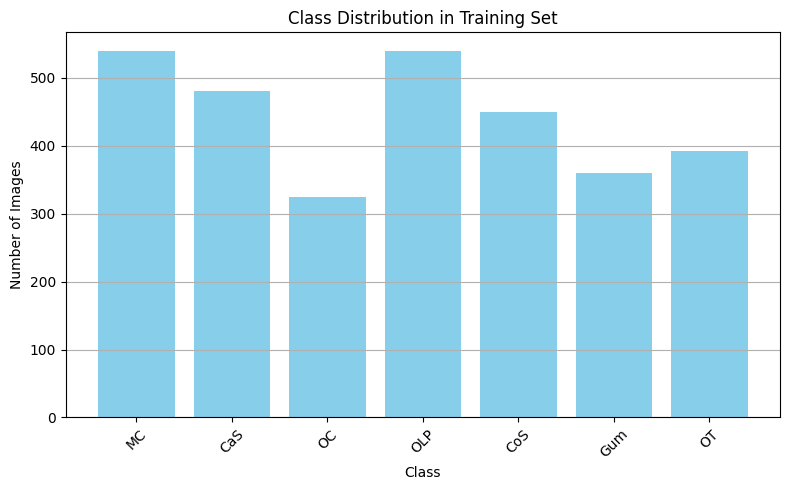

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Count classes in validation set


In [ ]:
val_class_counts = {}

for images, labels in val_ds.unbatch():
    label = int(labels.numpy())
    val_class_counts[class_names[label]] = val_class_counts.get(class_names[label], 0) + 1

## Visualize validation set distribution




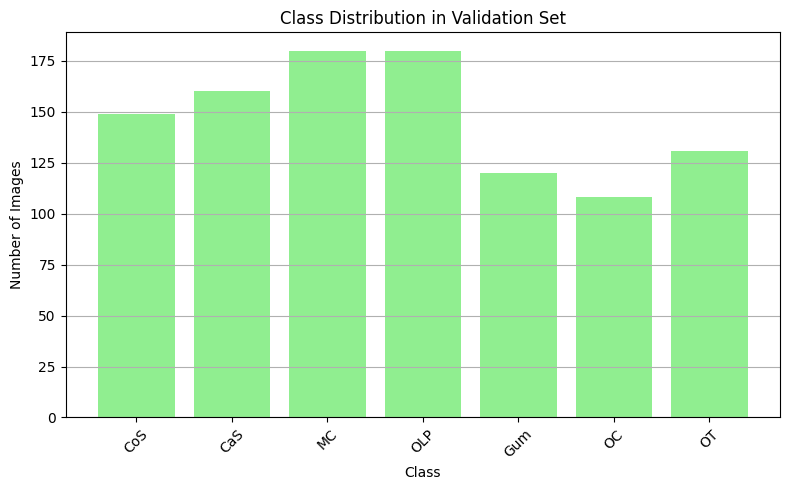

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(val_class_counts.keys(), val_class_counts.values(), color='lightgreen')
plt.title("Class Distribution in Validation Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Count classes in test set


In [ ]:
test_class_counts = {}

for images, labels in test_ds.unbatch():
    label = int(labels.numpy())
    test_class_counts[class_names[label]] = test_class_counts.get(class_names[label], 0) + 1

## Visualize test set distribution


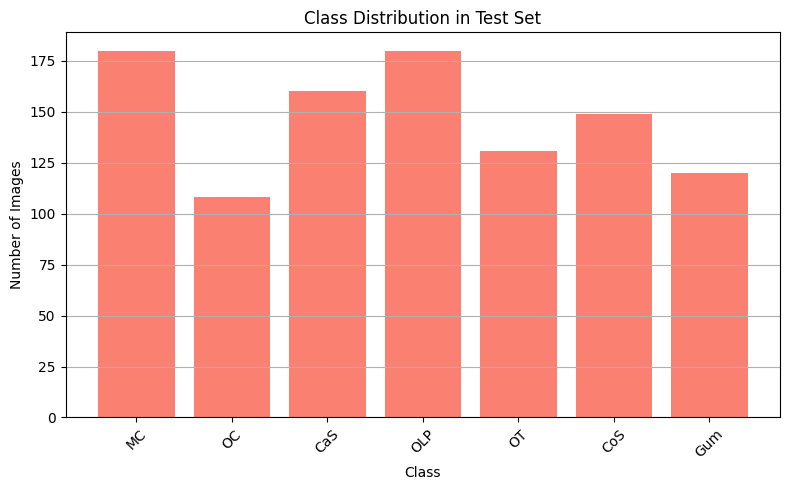

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(test_class_counts.keys(), test_class_counts.values(), color='salmon')
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Before & After Augmantationn:

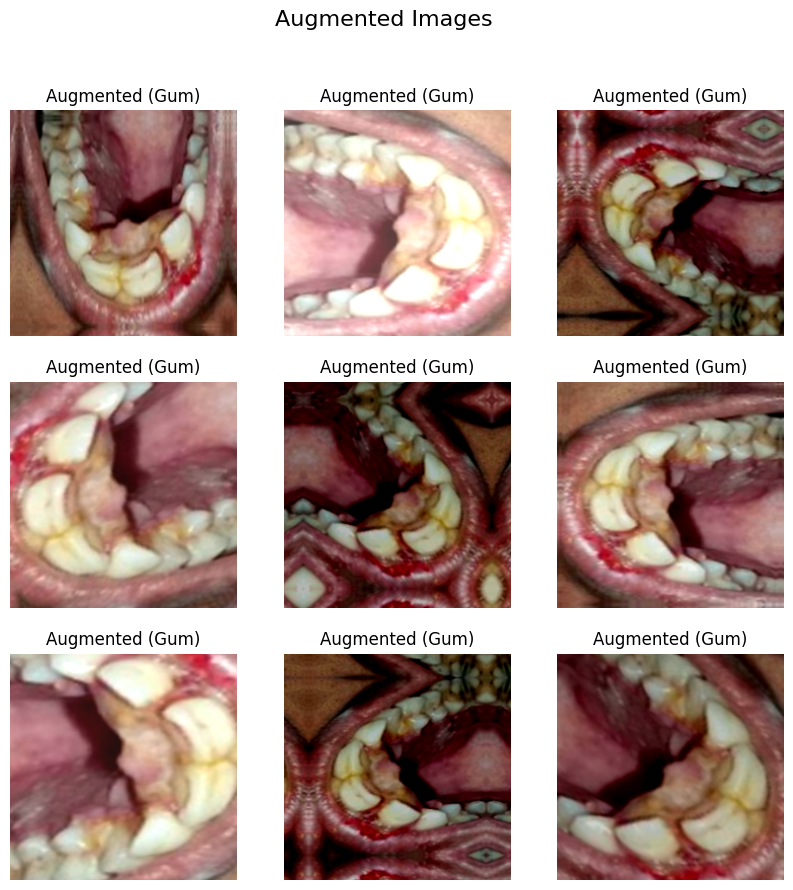

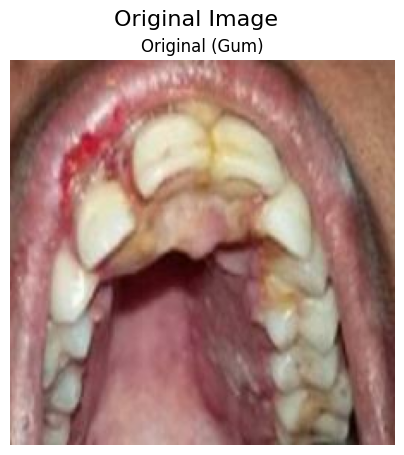

In [ ]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    first_label = labels[0]
    for i in range(9):
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented ({class_names[first_label]})")
        plt.axis("off")
    _ = plt.suptitle("Augmented Images", fontsize=16)

    plt.figure(figsize=(5, 5))
    plt.imshow(first_image.numpy().astype("uint8"))
    plt.title(f"Original ({class_names[first_label]})")
    plt.axis("off")
    _ = plt.suptitle("Original Image", fontsize=16)
    plt.show()
    break # Only display the first batch

# MobileNet Model:

In [ ]:
IMG_SHAPE = IMAGE_SIZE + (3,)
num_classes = 7
MobelNet_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
MobelNet_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

In [ ]:
model = tf.keras.Sequential([MobelNet_model,
                             global_average_layer,
                             prediction_layer])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(augmented_train_ds, epochs=100,validation_data=val_ds, class_weight=class_weights)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 66s 150ms/step - accuracy: 0.1681 - loss: 2.6318 - val_accuracy: 0.1722 - val_loss: 2.3350
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.1683 - loss: 2.3900 - val_accuracy: 0.1683 - val_loss: 2.2052
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.1944 - loss: 2.2252 - val_accuracy: 0.1839 - val_loss: 2.1244
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1769 - loss: 2.1632 - val_accuracy: 0.1858 - val_loss: 2.0685
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.1926 - loss: 2.1102 - val_accuracy: 0.1965 - val_loss: 2.0250
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.2062 - loss: 2.0582 - val_accuracy: 0.2082 - val_loss: 1.9868
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2216 - loss: 2.0139 - val_accuracy: 0.2364 - val_loss: 1.9495
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.2274 - loss: 1.9471 - val_accuracy: 

In [ ]:
test_loss_mobilenet, test_acc_mobilenet = model.evaluate(test_ds)
print(f"MobileNet Test Accuracy: {test_acc_mobilenet:.2f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.6762 - loss: 0.9357
MobileNet Test Accuracy: 0.66


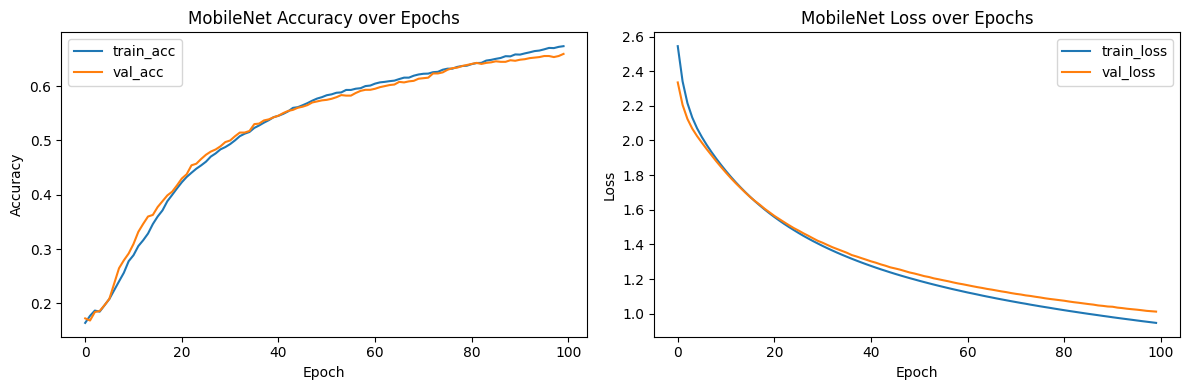

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("MobileNet Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("MobileNet Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Cellula internship/Week2/mobilenet_model.h5')

In [ ]:
model.save('/content/gdrive/MyDrive/Cellula internship/Week2/mobilenet_model.h5')

# Efficientnet model


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
IMAGE_SIZE = (224, 224)
IMG_SHAPE = IMAGE_SIZE + (3,)
efficientnet_model = EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
efficientnet_model.trainable = False

global_average_layer_efficientnet = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer_efficientnet = tf.keras.layers.Dense(num_classes, activation='softmax')

efficientnet_model = tf.keras.Sequential([efficientnet_model,
                             global_average_layer_efficientnet,
                             prediction_layer_efficientnet])

efficientnet_model.trainable = True

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Determine the number of layers to freeze. Freezing a significant portion of the base model is a common practice.
freeze_until_layer = 20

print(f"Number of layers in the EfficientNet model: {len(efficientnet_model.layers[0].layers)}")

# Iterate through the layers of the EfficientNet model and set the first 'freeze_until_layer' layers to non-trainable.
for i, layer in enumerate(efficientnet_model.layers[0].layers):
    if i < freeze_until_layer:
        layer.trainable = False
    else:
        layer.trainable = True

print(f"Froze the first {freeze_until_layer} layers of the EfficientNet base model.")

for i, layer in enumerate(efficientnet_model.layers[0].layers):
    print(f"Layer {i}: {layer.name} is trainable: {layer.trainable}")

Number of layers in the EfficientNet model: 238
Froze the first 20 layers of the EfficientNet base model.
Layer 0: input_layer_1 is trainable: False
Layer 1: rescaling is trainable: False
Layer 2: normalization is trainable: False
Layer 3: rescaling_1 is trainable: False
Layer 4: stem_conv_pad is trainable: False
Layer 5: stem_conv is trainable: False
Layer 6: stem_bn is trainable: False
Layer 7: stem_activation is trainable: False
Layer 8: block1a_dwconv is trainable: False
Layer 9: block1a_bn is trainable: False
Layer 10: block1a_activation is trainable: False
Layer 11: block1a_se_squeeze is trainable: False
Layer 12: block1a_se_reshape is trainable: False
Layer 13: block1a_se_reduce is trainable: False
Layer 14: block1a_se_expand is trainable: False
Layer 15: block1a_se_excite is trainable: False
Layer 16: block1a_project_conv is trainable: False
Layer 17: block1a_project_bn is trainable: False
Layer 18: block2a_expand_conv is trainable: False
Layer 19: block2a_expand_bn is trainabl

In [ ]:
efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
efficientnet_history = efficientnet_model.fit(augmented_train_ds, epochs=100, validation_data=val_ds, class_weight=class_weights)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 180s 610ms/step - accuracy: 0.2099 - loss: 1.9481 - val_accuracy: 0.1693 - val_loss: 1.9507
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.3579 - loss: 1.7744 - val_accuracy: 0.1469 - val_loss: 1.9484
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 112ms/step - accuracy: 0.4223 - loss: 1.6362 - val_accuracy: 0.1342 - val_loss: 2.5707
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.5231 - loss: 1.4919 - val_accuracy: 0.1420 - val_loss: 2.8232
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.5550 - loss: 1.3629 - val_accuracy: 0.1498 - val_loss: 1.9596
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.6069 - loss: 1.2572 - val_accuracy: 0.2082 - val_loss: 1.8828
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.6355 - loss: 1.1580 - val_accuracy: 0.2977 - val_loss: 1.7386
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.6658 - loss: 1.0740 -

In [ ]:
test_loss_efficientnet, test_acc_efficientnet = efficientnet_model.evaluate(test_ds)
print(f"EfficientNet Test Accuracy: {test_acc_efficientnet:.2f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9515 - loss: 0.1366
EfficientNet Test Accuracy: 0.95


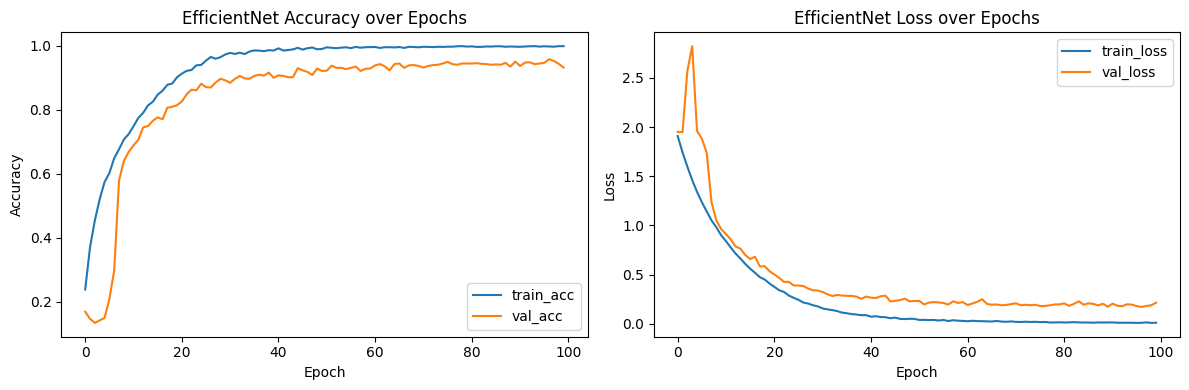

In [ ]:
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(efficientnet_history.history['accuracy'], label='train_acc')
plt.plot(efficientnet_history.history['val_accuracy'], label='val_acc')
plt.title("EfficientNet Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(efficientnet_history.history['loss'], label='train_loss')
plt.plot(efficientnet_history.history['val_loss'], label='val_loss')
plt.title("EfficientNet Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

**Reasoning**:
Save the trained EfficientNet model to Google Drive so it can be reused later without retraining.

In [ ]:
efficientnet_model.save('/content/gdrive/MyDrive/Cellula internship/Week2/efficientnet_modelwith20false.h5')

In [ ]:
efficientnet_model.save('/content/gdrive/MyDrive/Cellula internship/Week2/efficientnet_modelwith20false.keras')

In [ ]:
print(tf.keras.__version__)

3.8.0
